# Cross-Validation Training

In [76]:
# Import necessary packages. 
import pandas as pd
import numpy as np 
import math
import time
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import copy

## Data Preparation

In [19]:
# Reading data.
ml_df = pd.read_csv("sources/ML_model/output/ml_data.csv", header=0)

# Create the shuffled dataframe for randomly selecting the folds. 
ml_df_shuf = ml_df.sample(frac=1)

# Define number of folds. 
k = 4

# Create index for the folds. 
folds_index = list(range(0, ml_df_shuf.shape[0], math.ceil(ml_df_shuf.shape[0]/k))) + [ml_df_shuf.shape[0]]
folds_index = [[folds_index[i]+1, folds_index[i+1]] for i in range(len(folds_index)-1)]
folds_index[0][0] = 0
folds_index

[[0, 303615], [303616, 607230], [607231, 910845], [910846, 1214460]]

In [89]:
# Creating label and feature dataset. 
label = ml_df_shuf["valid"].to_numpy()
features_orig = pd.get_dummies(ml_df_shuf.drop(columns=["valid"]))
features = features_orig.to_numpy() 
print(label[0:5])
print(features[0:5,:])

[0.16390333 0.0377395  0.30630831 0.05606    0.11601658]
[[0.14298705 0.20360121 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         1.        ]
 [0.04412209 0.3374507  0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         1.         0.         0.        ]
 [0.46361867 0.23468205 0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.        ]
 [0.05444066 0.10581294 0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         1.        ]
 [0.20938928 0.45680226 0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         1.         0.        ]]


## Cross-Validation Training

In [ ]:
def time_stamp(): 
    print("[{}]".format(time.time()))

In [78]:
def cv_train(model_name, label, feature, folds): 
    predicted_set = {}
    iter_index = 0

    for validation_set in folds: 
        print("---- Creating Validation Set for data in range {}".format(validation_set))
        if model_name == "RF": 
            regr = RandomForestRegressor()
        else: 
            # Part for adding more models later. 
            print("#### Invalid Model Name. Terminating Training")
            break

        # Creating train and valid features, labels. 
        curr_test_feature = feature[validation_set[0]:validation_set[1],:]
        curr_test_label = label[validation_set[0]:validation_set[1]]
        curr_train_feature = np.delete(feature, np.s_[validation_set[0]:validation_set[1]+1], axis=0)
        curr_train_label = np.delete(label, np.s_[validation_set[0]:validation_set[1]+1], axis=0)

        start_time = time.time()
        print("-------- Start Training on {}".format(start_time))
        regr.fit(curr_train_feature, curr_train_label)
        print("-------- Finished Training, elapsed time: {}".format(time.time() - start_time))
        predicted_set[iter_index] = {
            "model": regr, 
            "predicted": regr.predict(curr_test_feature),
            "test_label": curr_test_label,
            "avocado": curr_test_feature[:,0],
            "curr_impute": curr_test_feature[:,1]
        }
        iter_index += 1

    return predicted_set

In [79]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [77]:
model_dic = cv_train("RF", label, features, folds_index)

---- Creating Validation Set for data in range [0, 303615]
-------- Start Training on 1574142000.716201
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 63.56887698173523
---- Creating Validation Set for data in range [303616, 607230]
-------- Start Training on 1574142066.1601129
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 57.79417419433594
---- Creating Validation Set for data in range [607231, 910845]
-------- Start Training on 1574142125.823922
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn

In [80]:
# Calculating the MSE for each fold. 
MSE_dict = {}
for i in range(4): 
    MSE_dict[i] = {
        "predicted": round(np.mean(abs(model_dic[i]["predicted"]-model_dic[i]["test_label"])), 4), 
        "avocado": round(np.mean(abs(model_dic[i]["avocado"]-model_dic[i]["test_label"])), 4),
        "curr_impute": round(np.mean(abs(model_dic[i]["curr_impute"]-model_dic[i]["test_label"])), 4)
    }
pretty(MSE_dict)

0
	predicted
		0.1393
	avocado
		0.1559
	curr_impute
		0.2804
1
	predicted
		0.1402
	avocado
		0.1606
	curr_impute
		0.2869
2
	predicted
		0.1357
	avocado
		0.151
	curr_impute
		0.2773
3
	predicted
		0.1357
	avocado
		0.1513
	curr_impute
		0.2771


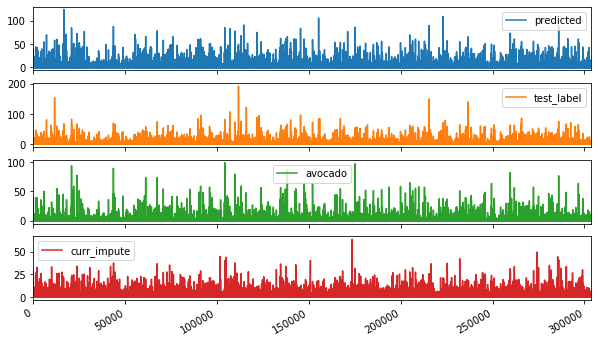

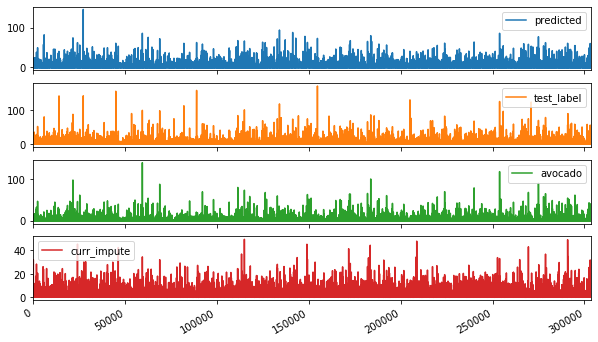

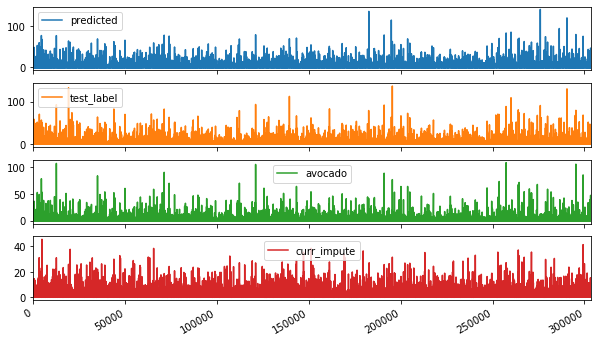

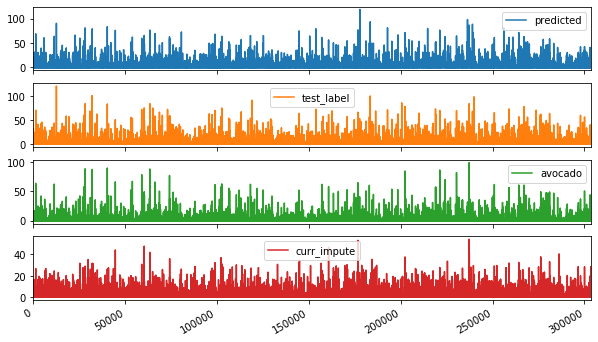

In [81]:
# Pairwise Data Visualization. 
for i in range(4): 
    temp_dic = copy.deepcopy(model_dic[i])
    temp_dic.pop("model")
    temp_plot_df = pd.DataFrame(temp_dic)
    temp_plot_df.plot(subplots=True, figsize=(10, 6))

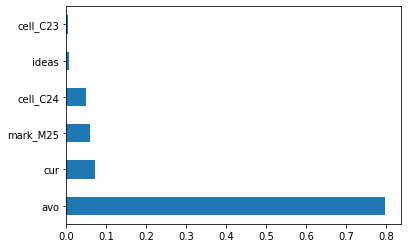

In [94]:
# Plot the feature importance. 
feat_imp_li = model_dic[0]["model"].feature_importances_
feat_importance = pd.Series(feat_imp_li, index=features_orig.columns)
feat_importance.nlargest(6).plot(kind='barh')
# print(model_dic[0]["model"].feature_importances_)

## Cross-Validated Training on Datasets Without IDEAS State

In [83]:
print(features[0,:])

[0.14298705 0.20360121 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         1.        ]


In [84]:
# Remove all IDEAS State dummies variable. 
features_id_rmd = features[:,0:2]
features_id_rmd[0,:]

array([0.14298705, 0.20360121])

In [85]:
model_dic_id_rmd = cv_train("RF", label, features_id_rmd, folds_index)

---- Creating Validation Set for data in range [0, 303615]
-------- Start Training on 1574142733.138905
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 55.296984910964966
---- Creating Validation Set for data in range [303616, 607230]
-------- Start Training on 1574142790.350058
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 45.43948006629944
---- Creating Validation Set for data in range [607231, 910845]
-------- Start Training on 1574142837.659648
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn

In [88]:
# Calculating the MSE for each fold. 
MSE_dict = {}
for i in range(4): 
    MSE_dict[i] = {
        "predicted": round(np.mean(abs(model_dic_id_rmd[i]["predicted"]-model_dic_id_rmd[i]["test_label"])), 4), 
        "avocado": round(np.mean(abs(model_dic_id_rmd[i]["avocado"]-model_dic_id_rmd[i]["test_label"])), 4),
        "curr_impute": round(np.mean(abs(model_dic_id_rmd[i]["curr_impute"]-model_dic_id_rmd[i]["test_label"])), 4)
    }
pretty(MSE_dict)

0
	predicted
		0.1748
	avocado
		0.1559
	curr_impute
		0.2804
1
	predicted
		0.1766
	avocado
		0.1606
	curr_impute
		0.2869
2
	predicted
		0.1703
	avocado
		0.151
	curr_impute
		0.2773
3
	predicted
		0.1716
	avocado
		0.1513
	curr_impute
		0.2771
